#### Imports

In [1]:
import pandas as pd 
import numpy as np

from env import username, password, get_db_url
import os

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoLars
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector

import wrangle
import zillow

| Feature | Definition |
|:--------|:-----------|
|bedrooms| The number of bedrooms in a single family residence|
|bathrooms| The number of bathrooms in a single family residence|
|sqft| The amount of square feet in a single family residence|
|property_value| The price a single family residence sold for|
|year_built| The year the single family residence was built|
|county| The county the single family residence is located in|
|rmse| Root Mean Squared Error, accuracy of regression model|
|r2| R-squared (R^2) is a statistical measure that represents the proportion of the variance. 1 = best, 0 = worst|

# Goal
* Predict the property tax assessed values of Single Family Properties by using 2017 Zillow transaction data.

# Wrangle

In [2]:
# acquire data from MySQL database
df = wrangle.get_zillow_data()

# clean data and handle outliers
df = wrangle.wrangle_zillow(df)

# create dummy columns for modeling phase
df = wrangle.create_dummy_variables(df)

# split into train, validate, test
train, validate, test = wrangle.split_function(df)

Found CSV


## Takeaways

* Original data set (52,442 rows)
* Dropped 199 nulls
* I defined single family residence as the following:
    * At least:
        * 1 Bedroom
        * 1 Bathroom
* Handled outliers:
    * Dropped 8+ bedroom homes
    * Dropped 7+ bathroom homes
    * Dropped sqft below 500 and 3 standard deviations above the mean sqft
    * Dropped property_value less than 100,000 and greater than .95 quantile
* Dropped 10,456 rows of data
* 80% of the original data is remaining
* Mapped county to county code
* Created dummy columns for ML model
* Split into train, validate, test


# Explore

#### Does the number of bathrooms have an impact on the square footage of single family properties?

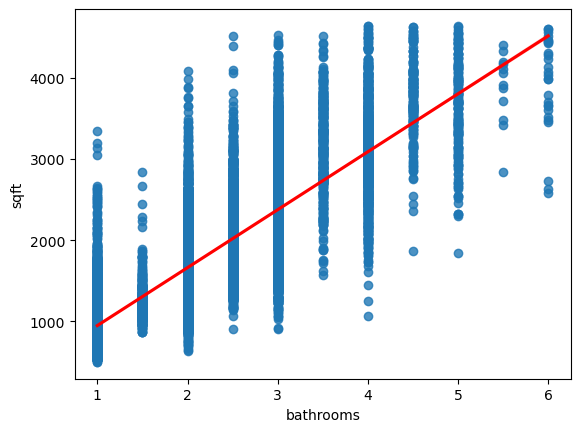

r = 0.8166932859154683
p = 0.0
There is a relationship between the number of bathrooms and the square footage of a single family property


In [3]:
# this function plots 2 variables, returns r & p values, returns if there is statistical significance or not
zillow.bath_sqft_relationship(train)

#### Does home value increase and decrease respectively with the square footage of a single family property?

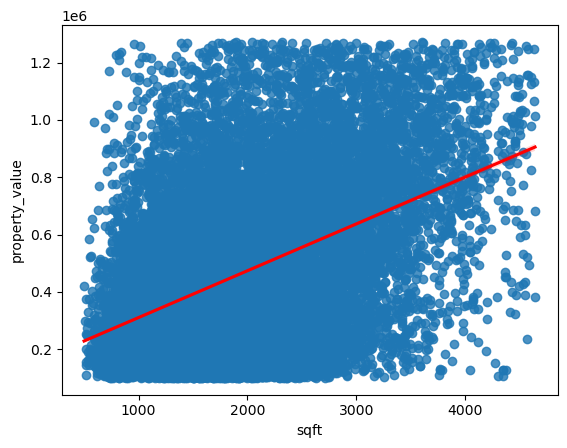

r = 0.40467921112300553
p = 0.0
There is a relationship between the property value and the square footage of a single family property


In [4]:
# this function plots 2 variables, returns r & p values, returns if there is statistical significance or not
zillow.sqft_value_relationship(train)

#### Does the number of bathrooms have an impact on the home value of single family properties?

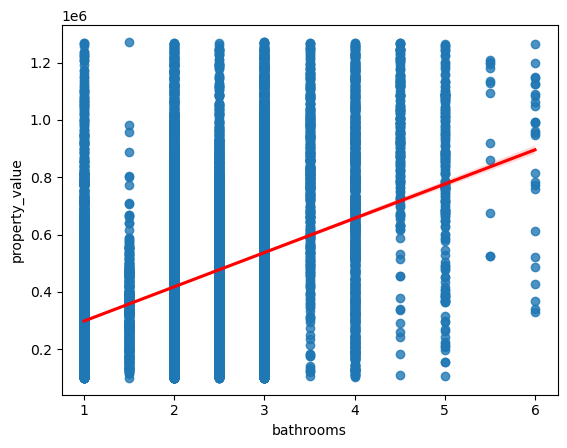

r = 0.3477310800774655
p = 0.0
There is a relationship between the number of bathrooms and the property value of a single family property


In [5]:
# this function plots 2 variables, returns r & p values, returns if there is statistical significance or not
zillow.bathroom_value_relationship(train)

#### Does the age of the home have an impact on the size of the home (sqft)?

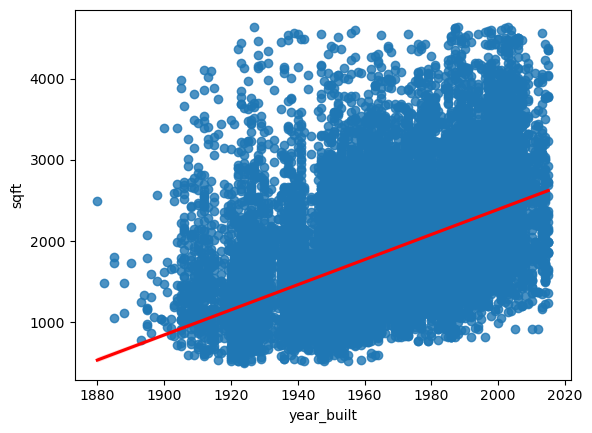

r = 0.5184390699385084
p = 0.0
There is a relationship between the age of a home and the sqft of a single family property


In [6]:
# this function plots 2 variables, returns r & p values, returns if there is statistical significance or not
zillow.age_sqft_relationship(train)

## Explore Summary
- Bathrooms are statistically significant to both sqft and property value.
- Sqft is statistically significant to year built and property value.
- I was not surprised by any of the outcomes. They all made sense, wanted to verify significance.

# Scale data

***Utilized MinMax Scaler***

In [7]:
# Identify columns to scale for model
to_scale = ['bedrooms', 'bathrooms', 'sqft', 'year_built']

# Send in train, validate, test and receive scaled train, validate, and test
train_scaled, validate_scaled, test_scaled = zillow.scale_data(train, validate, test, to_scale)

In [8]:
# Identify columns to drop before modeling
drop_cols = ['orange', 'ventura']

# Initiate X_train, X_validate, X_test, y_train, y_validate, y_test with scaled data
X_train, X_validate, X_test, y_train, y_validate, y_test = zillow.Xy_train_val_test(train_scaled, 
                                                                                 validate_scaled, 
                                                                                 test_scaled, 
                                                                                 'property_value', 
                                                                                 drop_cols)

Baseline Accuracy: 447616.3455996189


# Modeling

***Evaluated models by RMSE***

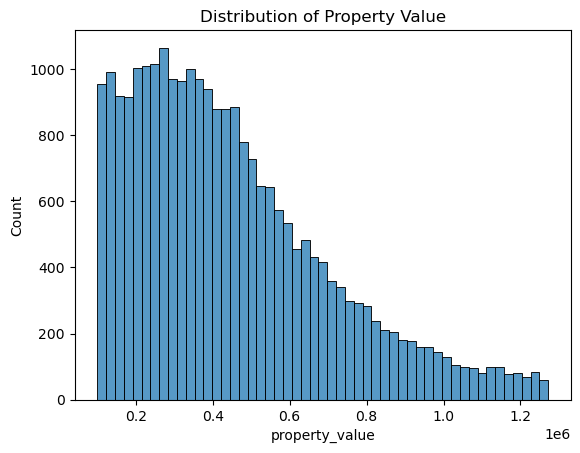

In [9]:
sns.histplot(y_train)
plt.title('Distribution of Property Value')
plt.show()

In [10]:
# function contains all models and returns a dataframe with rmse score along with r2
pred_lr1, pred_pr, pred_glm, metrics_df = zillow.zillow_models(train, X_train, X_validate, y_train, y_validate)
metrics_df

,model,rmse,r2
0,baseline,255366.694008,0.000000
1,Ordinary Least Squares,224701.241742,0.245782
2,LassoLars,224701.213436,0.245782
3,Polynomial Regression,222842.054645,0.258211
4,Generalized Linear Model,225796.719929,0.238410


In [11]:
# function contains best model and evaluates on test data to return rmse and r2
rmse, r2 = zillow.best_model(X_train, X_validate, X_test, y_train, y_test)
rmse, r2

(221812.29876899594, 0.2623194979678486)

## Modeling Takeaways
- All models performed better than baseline
    - I wouldn't be confident submitting this model for production
- Best model was Polynomial Regression
    - Test score on best model (**RMSE** = 221,812 ,  $R^2$ = 26.23%)

#### Plot Predicted vs Actual Values

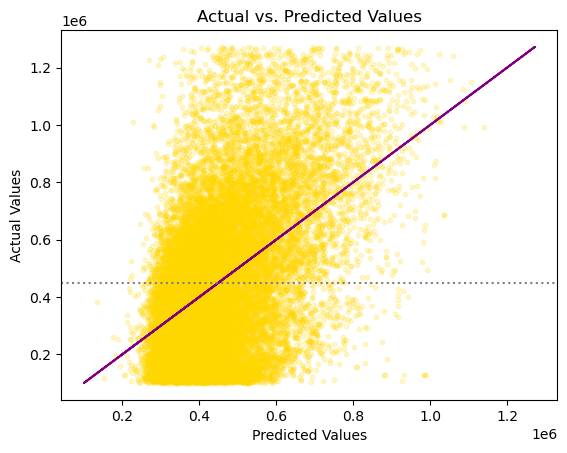

In [12]:
zillow.actual_pred_plot(pred_lr1, pred_pr, pred_glm, y_train)

# Conclusion

#### 1. California's housing prices are crazy

#### 2. Explore
    - Verified statistical significance for variables that help predict property value

#### 3. Modeling
    - Better than baseline but not good enough for production


# Recommendations / Next Steps
    - Use more features in future models
    - Explore more feature engineering in future models
#### With more time:
    - Explore the potential for building multiple models instead of a one size fits all approach

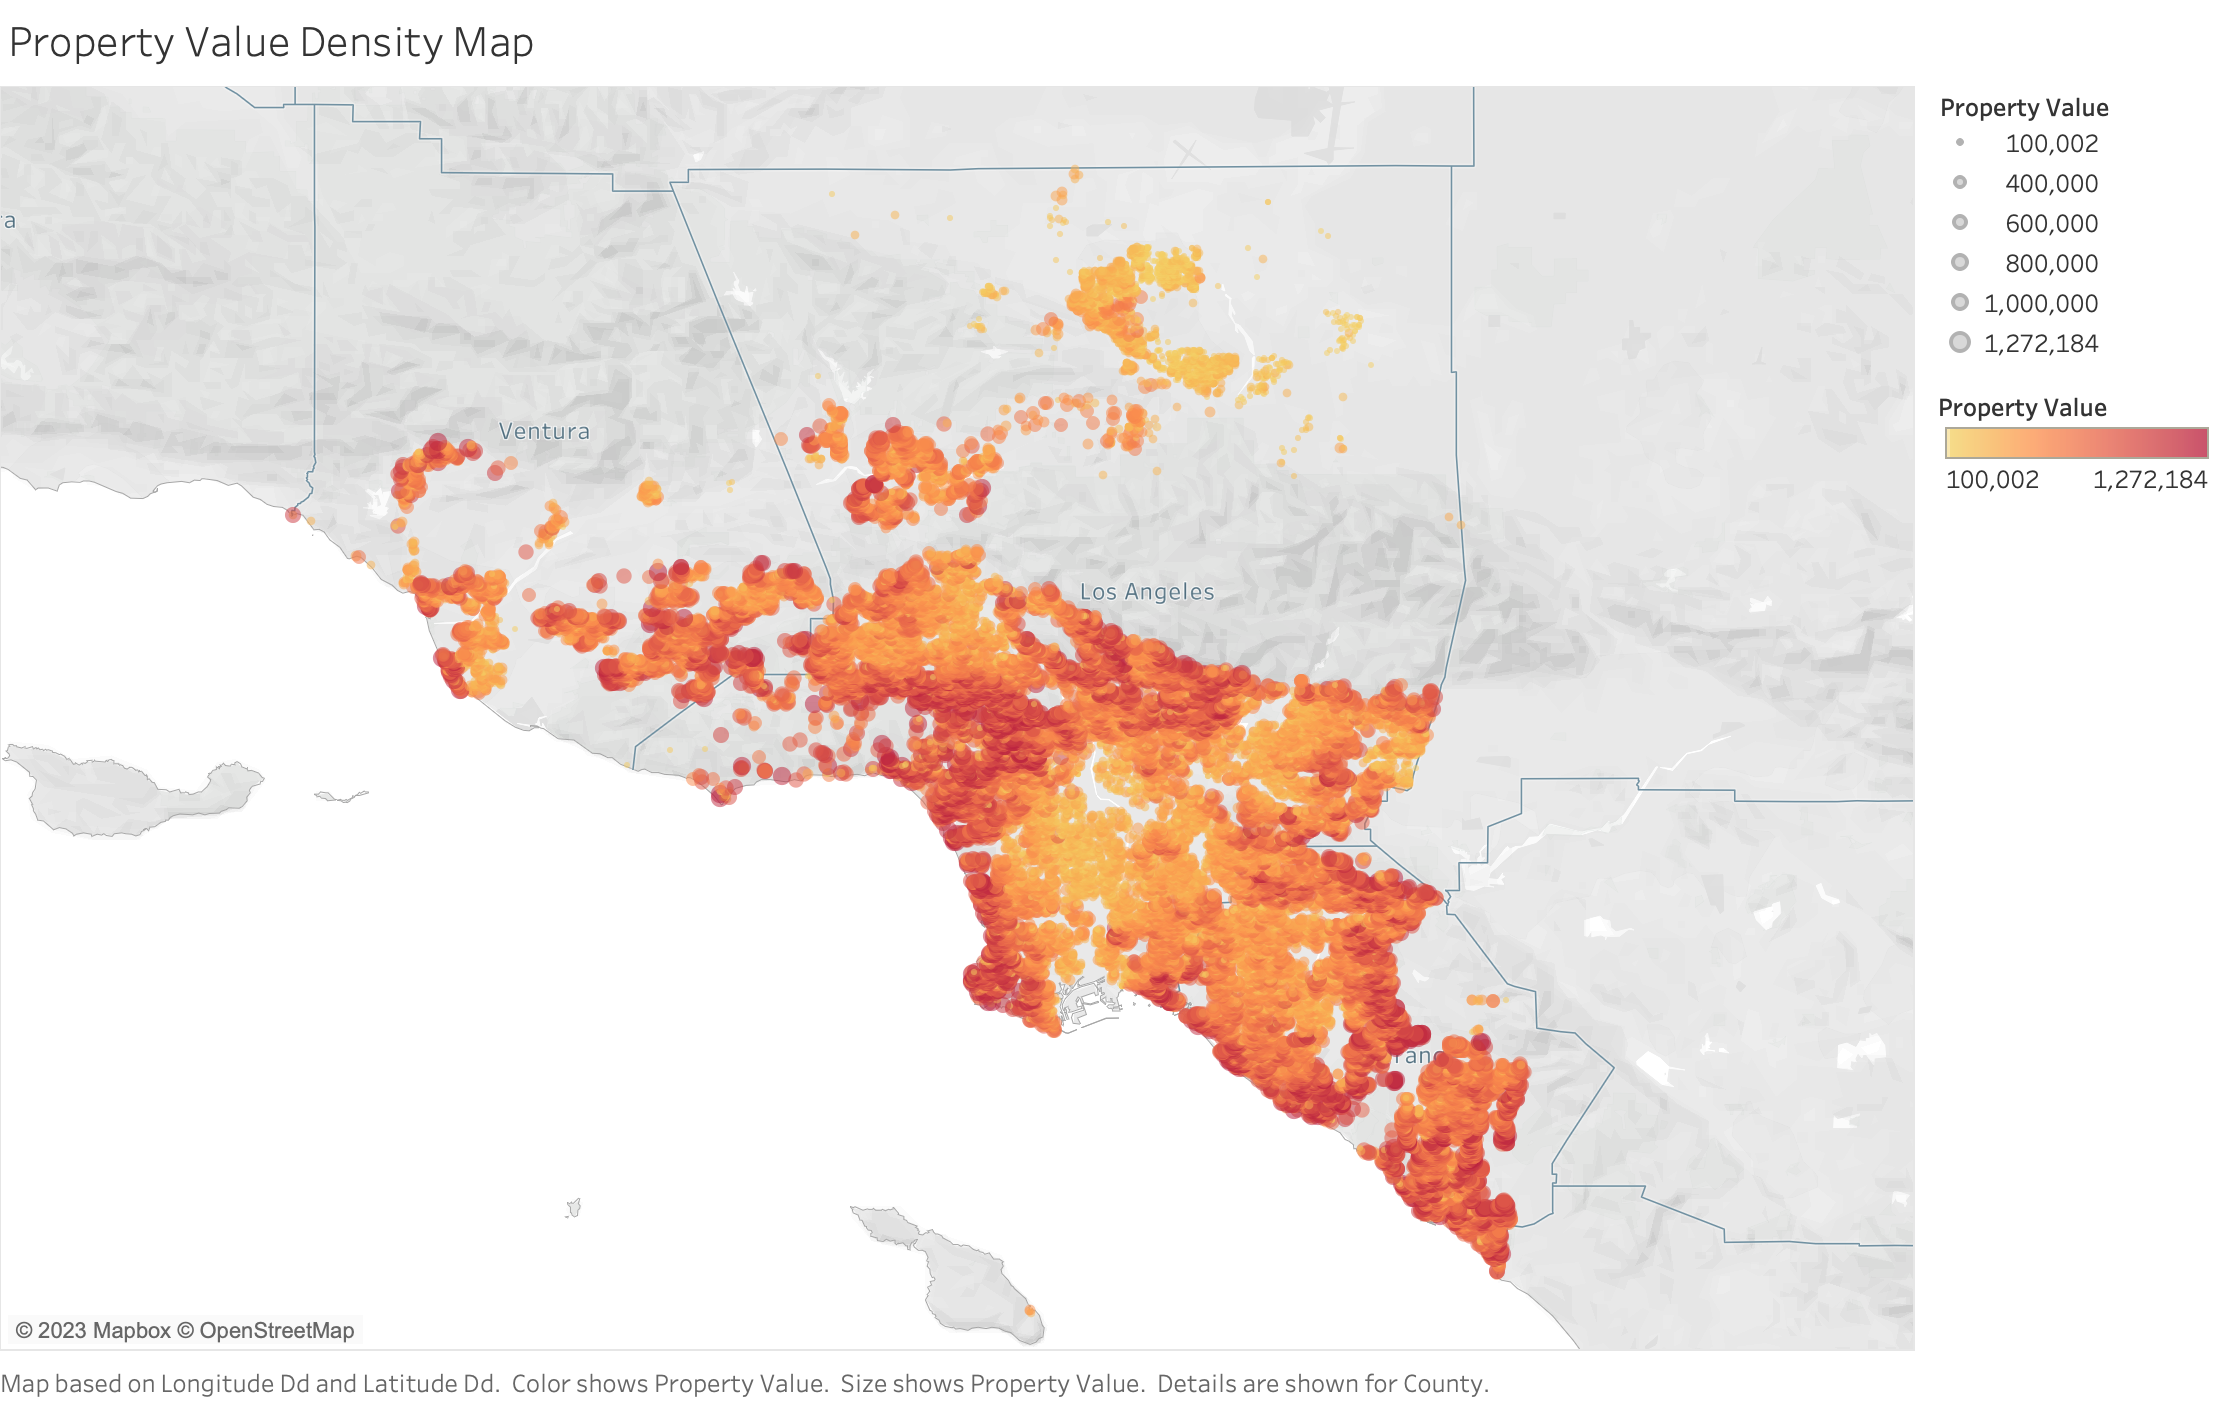